### Importing required libraries

In [35]:
%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display
from ipywidgets import *

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from sklearn import cross_validation
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LassoCV

### Utilities

In [29]:
# Regression plot showing predicted gF scores vs original gF scores
def regression_plot(x,y,n,title):

    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x,y,1)

    p = np.poly1d(z)
    fit = p(x)

    # get the coordinates for the fit curve
    c_x = [np.min(x),np.max(x)]
    c_y = p(c_x)

    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x)+1,1)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)         # mean of x
    DF = n - z.size                            # degrees of freedom
    t = stats.t.ppf(0.95,DF)           # used for CI and PI bands
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    #confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
    # now predict y based on test x-values
    p_y = z[0]*p_x+z[1]

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    # set-up the plot
    plt.subplots(figsize=(8,8))
    plt.axes().set_aspect('equal')
    plt.xlabel('Original score')
    plt.ylabel('Predicted score')
    plt.title(title)

    # plot sample data
    plt.plot(x,y,'bo')

    # plot line of best fit
    plt.plot(c_x,c_y,'r-',label='Regression line')

    # plot confidence limits
    plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')

    # set coordinate limits
    plt.xlim(4,25)
    plt.ylim(5,25)

    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)

    # add text
    rho,p = stats.pearsonr(np.ravel(y),x)
    s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
    plt.text(20, 7, s, fontsize=12)

    # show the plot
    plt.show()
    
    
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### Importing data

In [17]:
# finn's data set 
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)
print('No. of subjects:',n_subj)

No. of subjects: 115


In [27]:
#data = sio.loadmat('improved_preproc/rfMRI_REST1_HCP_Q2.mat')
data = sio.loadmat('improved_preproc/rfMRI_REST2_HCP_Q2.mat')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)

### gF score distribution 
The gF score is used to divide subjects in 2 or 3 classes.

(array([ 32.,  82.]), array([ 1. ,  1.5,  2. ]), <a list of 2 Patch objects>)

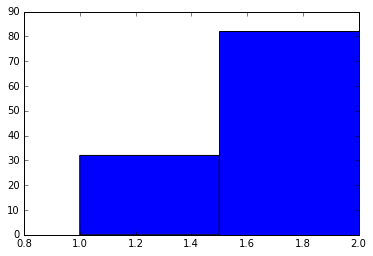

In [32]:
n_bins = 2

# needed for stratified k-fold
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits[:-1])
plt.hist(bins,n_bins)

### Building of input matrix
Starting from the connectivity matrices of each subject a #subjects x #edges matrix is built selecting for each subject the upper triangular matrix of the connectivity matrix (without the diagonal).

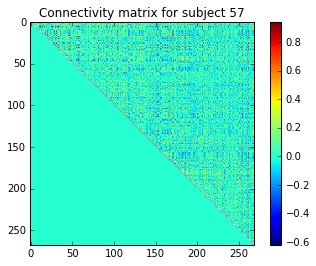

In [24]:
# choose dataset
#conn_mats = data['rest_1_mat']
conn_mats = data['rest_2_mat']

# build matrix n_subjects x n_edges
n_parcels = conn_mats.shape[0]
triu_idx = np.triu_indices(n_parcels,1)
n_edges = len(triu_idx[1]);

def plt_conn(subject):
    plt.imshow(np.triu(conn_mats[:,:,subject-1]))
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(subject))

interact(plt_conn, subject=(1,n_subj))    
    
    
edges = np.zeros([n_subj,n_edges])

for subject in range(conn_mats.shape[-1]):
    edges[subject,] = conn_mats[:,:,subject][triu_idx]

### Tests
Instead of performing regression in this experiment we try to divide subjects in 2 or 3 classes according to their gF score.

When performing PCA, select the number of components such that the amount of variance that needs to be explained is greater than 99.9%.

In [42]:
# Test with all edges (PCA in CV)
loo = cross_validation.LeaveOneOut(n_subj)
errors = np.zeros([n_subj,1])
predictions = np.zeros([n_subj,1])
#estimator =LinearSVC(random_state=0)
estimator = SVC(kernel='linear',probability=True,random_state=42)
pca = PCA(n_components=0.999)
prob = np.zeros([n_subj,n_bins])
i=0
f = FloatProgress(min=0, max=n_subj)
display(f)
for train_index, test_index in loo:
    # decomposition
    data_pc = pca.fit_transform(edges[train_index,])
    # regression
    estimator.fit(data_pc,bins[train_index])
    predictions[i] = estimator.predict(pca.transform(edges[test_index,]))
    prob[i,] = estimator.predict_proba(pca.transform(edges[test_index,]))
    errors[i] = 1 if predictions[i]==bins[test_index] else 0
    i += 1
    f.value += 1
        
print('Accuracy:',errors.mean())
preds = predictions


Accuracy: 0.69298245614


In [43]:
print(prob)

[[ 0.51352534  0.48647466]
 [ 0.42177959  0.57822041]
 [ 0.12076699  0.87923301]
 [ 0.19386005  0.80613995]
 [ 0.16842786  0.83157214]
 [ 0.26740803  0.73259197]
 [ 0.26093093  0.73906907]
 [ 0.31229983  0.68770017]
 [ 0.27937952  0.72062048]
 [ 0.24494266  0.75505734]
 [ 0.28355881  0.71644119]
 [ 0.26663524  0.73336476]
 [ 0.23319535  0.76680465]
 [ 0.35913605  0.64086395]
 [ 0.36100641  0.63899359]
 [ 0.31418396  0.68581604]
 [ 0.22670587  0.77329413]
 [ 0.16598358  0.83401642]
 [ 0.35470814  0.64529186]
 [ 0.29273515  0.70726485]
 [ 0.19063851  0.80936149]
 [ 0.28298331  0.71701669]
 [ 0.15308982  0.84691018]
 [ 0.27481432  0.72518568]
 [ 0.26991647  0.73008353]
 [ 0.28278346  0.71721654]
 [ 0.17123869  0.82876131]
 [ 0.42791118  0.57208882]
 [ 0.29903747  0.70096253]
 [ 0.19054962  0.80945038]
 [ 0.24018626  0.75981374]
 [ 0.22327568  0.77672432]
 [ 0.43422701  0.56577299]
 [ 0.28419965  0.71580035]
 [ 0.21036193  0.78963807]
 [ 0.16302597  0.83697403]
 [ 0.15143342  0.84856658]
 

In [44]:
confusion_matrix(bins, preds)

array([[ 1, 31],
       [ 4, 78]])

In [17]:
confusion_matrix(bins, preds_2)

array([[27, 25],
       [20, 42]])

In [20]:
confusion_matrix(bins, preds_3)

array([[ 1, 31],
       [ 6, 76]])

In [25]:
confusion_matrix(bins, preds_4)

array([[ 1, 31],
       [ 6, 76]])

### Classification and regression
Data are split in training and test set. Then the training set is used to train a classifier in order to divide data in two classes according to their gF score. Two regressor are built, one for each of the classes, still using training data alone. Finally the trained classifier is used to assign each sample of the test data to one of the two regressors.

In [47]:
n_bins = 2
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits[:-1])
print(bins)

[2 2 2 2 2 2 2 1 2 1 2 1 2 1 2 1 1 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2
 2 2 2 1 2 2 1 2 2 2 1 2 2 1 2 1 2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 2 2 2 2
 2 2 2 1 2 1 1 1 1 2 2 1 2 2 2 2 1 2 1 2 2 2 2 1 1 2 1 2 2 2 2 1 2 1 2 2 2
 2 2 1]


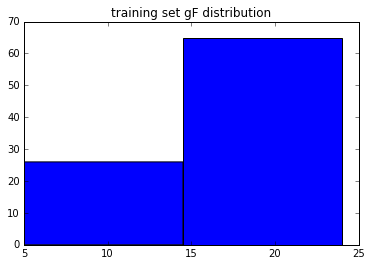

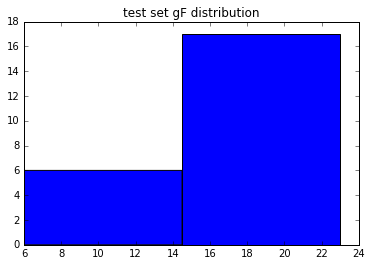

In [48]:
# Hold out set
X_train, X_test, y_train, y_test = cross_validation.train_test_split(edges,gF,test_size=0.2, random_state=42, stratify=bins)
test_bins = np.digitize(y_test, bin_limits[:-1])
train_bins = np.digitize(y_train, bin_limits[:-1])

plt.hist(y_train, bins=n_bins)
plt.title('training set gF distribution')
plt.show()
plt.hist(y_test, bins=n_bins)
plt.title('test set gF distribution')
plt.show()

In [66]:
errors_c = np.zeros([len(y_test)])
errors_r = np.zeros([len(y_test)])
predictions_c = np.zeros([len(y_test)])
predictions_r = np.zeros([len(y_test)])
#estimator = OneVsRestClassifier(LinearSVC(random_state=0))
estimator = LinearSVC(random_state=0)
pca = PCA(n_components=0.999)
k=5
n_bins_cv = 2

# decomposition
data_pc = pca.fit_transform(X_train)

# classification
estimator.fit(data_pc,train_bins)
predictions_c = estimator.predict(pca.transform(X_test))
errors_c = predictions_c==test_bins

# regressor for class 1
hist_cv, bin_limits_cv = np.histogram(y_train[train_bins==1], n_bins_cv)
bins_cv = np.digitize(y_train[train_bins==1], bin_limits_cv[:-1])
cv = cross_validation.StratifiedKFold(bins_cv,k)
#cv = cross_validation.KFold(k)
lasso = LassoCV(cv=cv,n_jobs=-1)
lasso.fit(X_train[train_bins==1,],y_train[train_bins==1])
predictions_r[predictions_c==1] = lasso.predict(X_test[predictions_c==1])
errors_r[test_bins==1] = abs(predictions_r[test_bins==1]-y_test[test_bins==1])

# regressor for class 2
hist_cv, bin_limits_cv = np.histogram(y_train[train_bins==2], n_bins_cv)
bins_cv = np.digitize(y_train[train_bins==2], bin_limits_cv[:-1])
cv = cross_validation.StratifiedKFold(bins_cv,k)
lasso = LassoCV(cv=cv,n_jobs=-1)
lasso.fit(X_train[train_bins==2,],y_train[train_bins==2])
predictions_r[predictions_c==2] = lasso.predict(X_test[predictions_c==2])      
errors_r[test_bins==2] = abs(predictions_r[test_bins==2]-y_test[test_bins==2])



The probabilities given in output by the classifier are used as weights to compute a linear combination of the output of the two regressors

In [51]:
errors_c = np.zeros([len(y_test)])
errors_r1 = np.zeros([len(y_test)])
errors_r2 = np.zeros([len(y_test)])
predictions_c = np.zeros([len(y_test)])
predictions_r1 = np.zeros([len(y_test)])
predictions_r2 = np.zeros([len(y_test)])
prob = np.zeros([len(y_test),2])

#estimator = OneVsRestClassifier(LinearSVC(random_state=0))
#estimator = LinearSVC(random_state=0)
estimator = SVC(kernel='linear',probability=True,random_state=0)
pca = PCA(n_components=0.999)
k=5
n_bins_cv = 2

# decomposition
data_pc = pca.fit_transform(X_train)

# classification
estimator.fit(data_pc,train_bins)
predictions_c = estimator.predict(pca.transform(X_test))
prob = estimator.predict_proba(pca.transform(X_test))
errors_c = predictions_c==test_bins

# regressor for class 1
hist_cv, bin_limits_cv = np.histogram(y_train[train_bins==1], n_bins_cv)
bins_cv = np.digitize(y_train[train_bins==1], bin_limits_cv[:-1])
cv = cross_validation.StratifiedKFold(bins_cv,k)
lasso = LassoCV(cv=cv,n_jobs=-1)
lasso.fit(X_train[train_bins==1,],y_train[train_bins==1])
predictions_r1 = lasso.predict(X_test)
errors_r1 = abs(predictions_r1-y_test)

# regressor for class 2
hist_cv, bin_limits_cv = np.histogram(y_train[train_bins==2], n_bins_cv)
bins_cv = np.digitize(y_train[train_bins==2], bin_limits_cv[:-1])
cv = cross_validation.StratifiedKFold(bins_cv,k)
lasso = LassoCV(cv=cv,n_jobs=-1)
lasso.fit(X_train[train_bins==2,],y_train[train_bins==2])
predictions_r2 = lasso.predict(X_test)      
errors_r2 = abs(predictions_r2-y_test)

final_preds = prob[:,0]*predictions_r1 + prob[:,1]*predictions_r2



In [60]:
print(final_preds)
print(y_test)

[ 16.78817621  16.79449873  16.16698028  16.32242964  16.50318109
  16.72517111  17.12017499  16.77752074  16.79746662  16.44549997
  16.62491928  17.46759334  16.8149031   16.63513961  16.38139242
  16.44757554  16.6544701   16.97434174  16.90784355  16.69727397
  16.66907056  16.60802469  16.92485291]
[19 16 20  7 21 18 20 23 15 10 20 19 13 16 18 21 20 20 19  7 22 12  6]


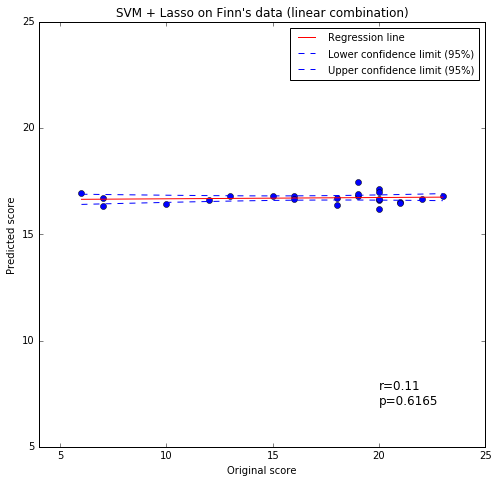

In [59]:
regression_plot(np.ravel(y_test),final_preds,len(y_test),'SVM + Lasso on Finn\'s data (linear combination)')

#### Preliminary test
In order to evaluate the performance of the double regression, an oracle is used instead of the classifier

In [11]:
errors_r = np.zeros([len(y_test)])
predictions_r = np.zeros([len(y_test)])

k=5
n_bins_cv = 2

# regressor for class 1
hist_cv, bin_limits_cv = np.histogram(y_train[train_bins==1], n_bins_cv)
bins_cv = np.digitize(y_train[train_bins==1], bin_limits_cv[:-1])
cv = cross_validation.StratifiedKFold(bins_cv,k)
#cv = cross_validation.KFold(k)
lasso = LassoCV(cv=cv,n_jobs=-1)
lasso.fit(X_train[train_bins==1,],y_train[train_bins==1])
predictions_r[test_bins==1] = lasso.predict(X_test[test_bins==1])
errors_r[test_bins==1] = abs(predictions_r[test_bins==1]-y_test[test_bins==1])

# regressor for class 2
hist_cv, bin_limits_cv = np.histogram(y_train[train_bins==2], n_bins_cv)
bins_cv = np.digitize(y_train[train_bins==2], bin_limits_cv[:-1])
cv = cross_validation.StratifiedKFold(bins_cv,k)
lasso = LassoCV(cv=cv,n_jobs=-1)
lasso.fit(X_train[train_bins==2,],y_train[train_bins==2])
predictions_r[test_bins==2] = lasso.predict(X_test[test_bins==2])      
errors_r[test_bins==2] = abs(predictions_r[test_bins==2]-y_test[test_bins==2])



In [67]:
print(confusion_matrix(test_bins, predictions_c))
print('Mean regression error:',errors_r.mean())

[[ 1  5]
 [ 1 16]]
Mean regression error: 3.87123911479


In [12]:
print('Mean regression error:',errors_r.mean())

Mean regression error: 1.93646968231


In [14]:
print(predictions_r)

[ 19.32678708  19.69442632  17.95923211  11.93222149  19.86805903
  18.66479361  19.28390395  19.3842552   20.07267152  10.36669783
  19.18010019  19.76105205  11.08494866  19.03395738  19.52445776
  19.50400842  19.85424396  19.51400362  20.14663027  10.18809713
  19.21307972  11.94585248  10.61869759]


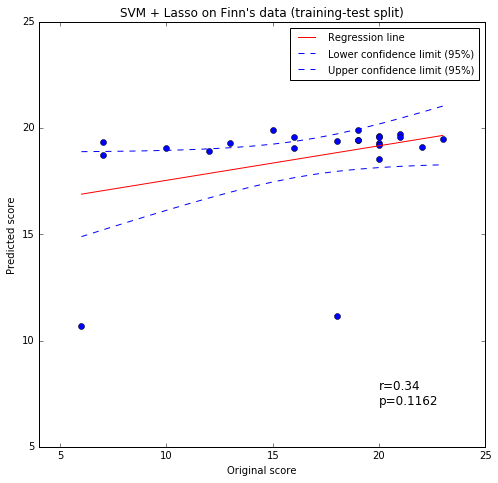

In [43]:
regression_plot(np.ravel(y_test),predictions_r,len(y_test),'SVM + Lasso on Finn\'s data (training-test split)')

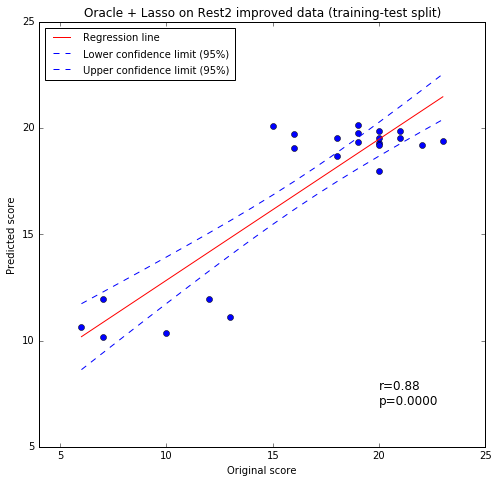

In [13]:
regression_plot(np.ravel(y_test),predictions_r,len(y_test),'Oracle + Lasso on Rest2 improved data (training-test split)')

Classification and regression with leave-one-out require much more time and I still have to select the final model

In [38]:
loo = cross_validation.LeaveOneOut(len(y_train))
errors_c = np.zeros([len(y_train),1])
errors_r = np.zeros([len(y_train),1])
predictions_c = np.zeros([len(y_train),1])
predictions_r = np.zeros([len(y_train),1])
estimator = OneVsRestClassifier(LinearSVC(random_state=0))
pca = PCA(n_components=0.999)
k=5
n_bins_cv = 4

i=0
f = FloatProgress(min=0, max=len(y_train))
display(f)
for train_index, test_index in loo:
    # decomposition
    data_pc = pca.fit_transform(X_train[train_index,])
    # regression
    estimator.fit(data_pc,bins[train_index])
    predictions_c[i] = estimator.predict(pca.transform(X_train[test_index,]))

    errors_c[i] = 1 if predictions[i]==bins[test_index] else 0
    i += 1
    f.value += 1
        
print('Accuracy:',errors_c.mean())
preds_5 = predictions


Accuracy: 0.692307692308


In [39]:
confusion_matrix(bins, preds_5)

array([[ 2, 24],
       [ 4, 61]])

In [ ]:
# TODO: merge to above cell
k=5
n_bins_cv = 4

f = FloatProgress(min=0, max=len(y_train))
display(f)
for train_index, test_index in loo:
    hist_cv, bin_limits_cv = np.histogram(y_train[train_index], n_bins_cv)
    bins_cv = np.digitize(y_train[train_index], bin_limits_cv[:-1])
    cv = cross_validation.StratifiedKFold(bins_cv,k)
    lasso = LassoCV(cv=cv,n_jobs=-1)
    lasso.fit(X_train[train_index,],y_train[train_index])
    predictions_r = lasso.predict(X_train[test_index,])
    errors_r[i] = abs(predictions[i]-y_train[test_index])

print('Mean error:',errors_r.mean())